# Get from Address to Model

In [39]:
import urllib
import requests
import json

## Geo-Admin API
Access of the API

In [40]:
#Definition of parameters
text = input("Please enter an address: ") #Input of the address to search for
base_url="https://api3.geo.admin.ch/rest/services/api/SearchServer?"
parameters = {"searchText": text, "origins": "address", "type": "locations",}

#Request
r = requests.get(f"{base_url}{urllib.parse.urlencode(parameters)}")

data = json.loads(r.content)
#print(data)

Geographic display of returned results

In [41]:
import folium

# Create a map centered at the first item's latitude and longitude
map_center = [data['results'][0]['attrs']['lat'], data['results'][0]['attrs']['lon']]
m = folium.Map(location=map_center, zoom_start=20)

# Add markers for each item with annotations
for i, result in enumerate(data['results']):
    lat = result['attrs']['lat']
    lon = result['attrs']['lon']
    label = f"Index: {i}"
    folium.Marker([lat, lon], popup=label).add_to(m)

# Display the map
m


In [42]:
#Select the desired item
index = int(input("Please enter the index of the item you want to select: "))
selected_building = data['results'][index]
#print(selected_building)


## KML files
Check KML files for desired building

In [43]:
import os
import re
import math

# Define the folder path
folder_path = "swissBUILDINGS3D"

# Get the latitude and longitude from the selected_item
lat = float(selected_building['attrs']['lat'])
lon = float(selected_building['attrs']['lon'])
print(f"Latitude: {lat}", f"Longitude: {lon}")

# Define the calculate_distance function
def calculate_distance(lat1, lon1, lat2, lon2):
    # Convert coordinates to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Haversine formula
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = 6371 * c  # Earth radius in kilometers

    return distance

# Search for KML files in the folder
kml_files = []
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith(".kml"):
            kml_files.append(os.path.join(root, file))

print(f"Found {len(kml_files)} KML files", kml_files)

# Define the tolerance in kilometers
tolerance = 0.01

# List to store the filtered KML data
filtered_kml_data = []

# Iterate through the KML files
for kml_file in kml_files:
    with open(kml_file, 'r') as file:
        kml_content = file.read()
        
        # Extract the latitude and longitude values from the KML content
        latitudes = re.findall(r'<latitude>(.*?)</latitude>', kml_content)
        longitudes = re.findall(r'<longitude>(.*?)</longitude>', kml_content)
        hrefs = re.findall(r'<href>(.*?)</href>', kml_content)
        
        # Convert the latitude and longitude values to float
        latitudes = [float(lat) for lat in latitudes]
        longitudes = [float(lon) for lon in longitudes]
        
        # Check if any entry is within the tolerance
        for i in range(len(latitudes)):
            distance = calculate_distance(lat, lon, latitudes[i], longitudes[i])
            if distance <= tolerance:
                filtered_kml_data.append((kml_file, latitudes[i], longitudes[i],  hrefs[i]))

# Print the filtered KML data
#for data in filtered_kml_data:
    #print(f"KML File: {data[0]}, Latitude: {data[1]}, Longitude: {data[2]}, href: {data[3]}")



Latitude: 47.63772201538086 Longitude: 8.691741943359375
Found 6 KML files ['swissBUILDINGS3D\\1031-44\\1031-44.kml', 'swissBUILDINGS3D\\1032-33\\1032-33.kml', 'swissBUILDINGS3D\\1032-34\\1032-34.kml', 'swissBUILDINGS3D\\1051-22\\1051-22.kml', 'swissBUILDINGS3D\\1052-11\\1052-11.kml', 'swissBUILDINGS3D\\1052-12\\1052-12.kml']


## Get model data from kml

In [44]:
import collada

kml = filtered_kml_data[0][0].split("\\")[1]
model = filtered_kml_data[0][3].split("/")[-1]

for data in filtered_kml_data:
    kml_file = data[0]
    lat = data[1]
    lon = data[2]
    href = data[3]
    
    # Load the COLLADA file
    coll = collada.Collada("swissBUILDINGS3D\\"+kml+"\\models\\"+model)
    #print ("swissBUILDINGS3D\\"+kml+"\\models\\"+model)
    # Extract the geometry
    #print(coll)
    #print(coll.geometries)
    #print(coll.geometries[0].primitives)
    #for i in coll.geometries[0].primitives[0]:
        #print(i)


In [45]:
import numpy as np
from ipygany import PolyMesh

meshes=[]

for i in range(len(coll.geometries)):
    
    vertices = []
    faces = []

    for triangle in coll.geometries[i].primitives[0]:
        # Extract the vertices of the triangle
        v1, v2, v3 = triangle.vertices
        
        # Add the vertices to the vertices list
        vertices.append(v1)
        vertices.append(v2)
        vertices.append(v3)
        
        # Calculate the indices of the vertices in the faces list
        index1 = len(vertices) - 3
        index2 = len(vertices) - 2
        index3 = len(vertices) - 1
        
        # Add the indices to the faces list
        faces.append([index1, index2, index3])

    # Convert the vertices and faces lists to numpy arrays
    vertices = np.array(vertices)
    faces = np.array(faces)

    # Create the PolyMesh
    mesh = PolyMesh(vertices=vertices, triangle_indices=faces)
    meshes.append(mesh)

#print(meshes[0].vertices)


In [46]:
#Draw the whole building
from ipygany import Scene

sceneHouse = Scene(meshes)
sceneHouse

Scene(children=[PolyMesh(data=[], triangle_indices=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, …

In [53]:
walls = [mesh for mesh in meshes if (mesh.vertices[2::3].max()- mesh.vertices[2::3].min())> 6]

sceneWalls = Scene(walls)
sceneWalls


Scene(children=[PolyMesh(data=[], triangle_indices=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, …

In [55]:
roof = [mesh for mesh in meshes if not (mesh.vertices[2::3].max()- mesh.vertices[2::3].min())> 6]

sceneRoof = Scene(roof)
sceneRoof

Scene(children=[PolyMesh(data=[], triangle_indices=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, …

In [56]:
num_triangles = len(walls[0].vertices)/9
ns_walls, we_walls = [], []
ns_vertices, we_vertices = [], []
ns_faces, we_faces = [], []
triangles = []
ns_index=0
we_index=0
for i in range(int(num_triangles)):
    triangle= walls[0].vertices[i*9:(i+1)*9]
    triangles.append(triangle)
for triangle in triangles:
    x1, y1, z1 = triangle[0], triangle[1], triangle[2]
    x2, y2, z2 = triangle[3], triangle[4], triangle[5]
    x3, y3, z3 = triangle[6], triangle[7], triangle[8]

    dir12 = np.array([abs(x2 - x1), abs(y2 - y1)])
    dir13 = np.array([abs(x3 - x1), abs(y3 - y1)])
    dir23 = np.array([abs(x3 - x2), abs(y3 - y2)])

    if(max(dir12[0], dir13[0], dir23[0])>max(dir12[1],dir13[1],dir23[1])):
        ns_vertices.append(triangle)
        ns_faces.append([ns_index, ns_index+1, ns_index+2])
        ns_index+=3

    else:
        we_vertices.append(triangle)
        we_faces.append([we_index, we_index+1, we_index+2])
        we_index+=3

ns_walls.append(PolyMesh(vertices=ns_vertices, triangle_indices=ns_faces))
we_walls.append(PolyMesh(vertices=we_vertices, triangle_indices=we_faces))

print(ns_walls)

sceneNS =Scene(we_walls)
sceneNS


[PolyMesh(data=[], triangle_indices=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41]), vertices=array([-6.74176872e-01,  9.06252766e+00,  4.28503998e+02, -6.90833628e-02,
        9.50488472e+00,  4.39678009e+02, -6.90833628e-02,  9.50488472e+00,
        4.28503998e+02, -6.74176872e-01,  9.06252766e+00,  4.40289001e+02,
       -6.90833628e-02,  9.50488472e+00,  4.39678009e+02, -6.74176872e-01,
        9.06252766e+00,  4.28503998e+02, -1.04738045e+01,  4.10580540e+00,
        4.38802002e+02, -1.72624612e+00,  1.05013981e+01,  4.40289001e+02,
       -1.72624612e+00,  1.05013981e+01,  4.28503998e+02, -5.39121532e+00,
        7.82180548e+00,  4.43993011e+02, -1.72624612e+00,  1.05013981e+01,
        4.40289001e+02, -1.04738045e+01,  4.10580540e+00,  4.38802002e+02,
       -1.04738045e+01,  4.10580540e+00,  4.38802002e+02, -1.72624612e+00,
        1.0501

Scene(children=[PolyMesh(data=[], triangle_indices=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, …

In [57]:
wallsNS2D, wallsWE2D = [], []
for i in range(len(ns_walls[0].vertices)):
    if not i % 3 == 2:
        wallsNS2D.append(ns_walls[0].vertices[i])

for i in range(len(we_walls[0].vertices)):
    if not i % 3 == 2:
        wallsWE2D.append(we_walls[0].vertices[i])


print(wallsNS2D)
print(wallsWE2D)

[-0.6741769, 9.062528, -0.06908336, 9.504885, -0.06908336, 9.504885, -0.6741769, 9.062528, -0.06908336, 9.504885, -0.6741769, 9.062528, -10.473804, 4.1058054, -1.7262461, 10.501398, -1.7262461, 10.501398, -5.3912153, 7.8218055, -1.7262461, 10.501398, -10.473804, 4.1058054, -10.473804, 4.1058054, -1.7262461, 10.501398, -10.473804, 4.1058054, -5.1858125, -0.35586074, -6.506286, -1.3208168, -6.506286, -1.3208168, -5.1858125, -0.35586074, -6.506286, -1.3208168, -5.1858125, -0.35586074, -0.8259589, -7.8288455, -0.107515335, -7.3022947, -0.107515335, -7.3022947, -0.8259589, -7.8288455, -0.107515335, -7.3022947, -0.8259589, -7.8288455, 10.473809, -6.1862383, 2.3272974, -12.14241, 2.3272974, -12.14241, 10.473809, -6.1862383, 2.3272974, -12.14241, 10.473809, -6.1862383, 6.80784, -8.865815, 2.3272974, -12.14241, 10.473809, -6.1862383, 5.255828, 2.2204957, 4.6507344, 1.7781389, 4.6507344, 1.7781389, 5.255828, 2.2204957, 4.6507344, 1.7781389, 5.255828, 2.2204957]
[-1.7262461, 10.501398, -0.6741769

w walls

w walls

w walls

w walls

w walls

w walls

w walls

w walls

same wall
same wall
w walls

same wall
same wall
w walls



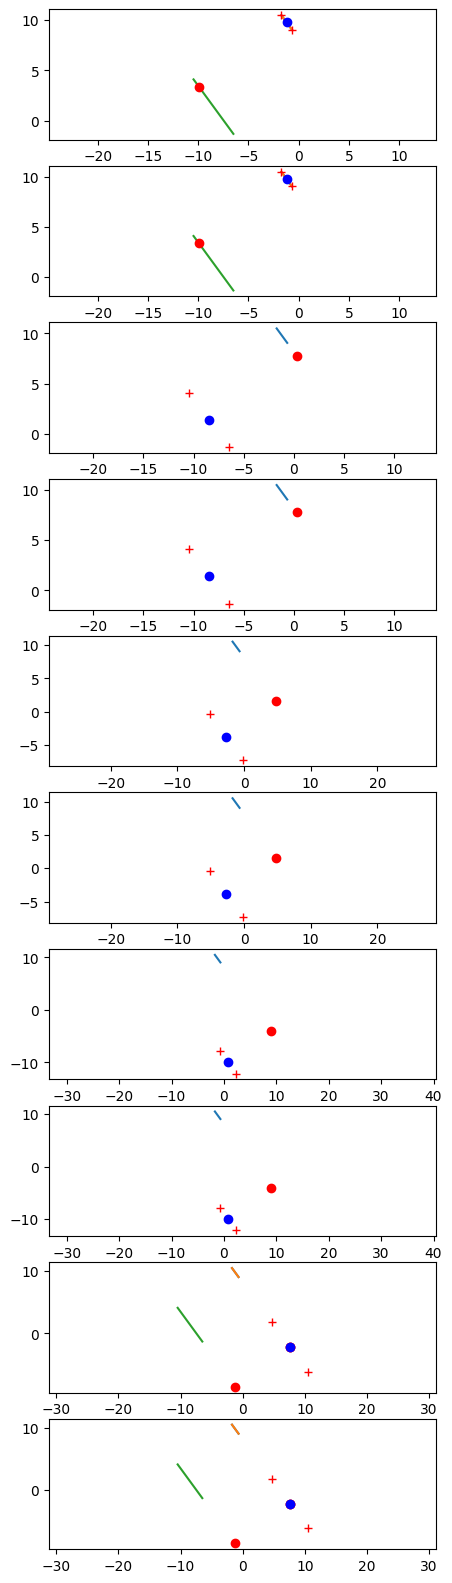

[PolyMesh(data=[])]
[PolyMesh(data=[], triangle_indices=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), vertices=array([-1.72624612e+00,  1.05013981e+01,  4.28503998e+02, -6.74176872e-01,
        9.06252766e+00,  4.40289001e+02, -6.74176872e-01,  9.06252766e+00,
        4.28503998e+02, -1.72624612e+00,  1.05013981e+01,  4.40289001e+02,
       -6.74176872e-01,  9.06252766e+00,  4.40289001e+02, -1.72624612e+00,
        1.05013981e+01,  4.28503998e+02, -6.50628614e+00, -1.32081676e+00,
        4.28503998e+02, -1.04738045e+01,  4.10580540e+00,  4.38802002e+02,
       -1.04738045e+01,  4.10580540e+00,  4.28503998e+02, -6.50628614e+00,
       -1.32081676e+00,  4.38803009e+02, -1.04738045e+01,  4.10580540e+00,
        4.38802002e+02, -6.50628614e+00, -1.32081676e+00,  4.28503998e+02,
       -1.07515335e-01, -7.30229473e+00,  4.28503998e+02, -5.18581247e+00,
       -3.55860740e-01,  4.40151001e+02, -5.18581

Scene(children=[PolyMesh(data=[], triangle_indices=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, …

In [59]:
from math import isclose
import matplotlib.pyplot as plt

n_walls, e_walls, s_walls, w_walls = [], [], [], []
n_walls_vertices, e_walls_vertices, s_walls_vertices, w_walls_vertices = [], [], [], []
vectorsNS=[]
vectorsWE=[]

for i in range(0, len(wallsNS2D), 6):
    x1, y1, x2, y2, x3, y3 = wallsNS2D[i], wallsNS2D[i+1], wallsNS2D[i+2], wallsNS2D[i+3], wallsNS2D[i+4], wallsNS2D[i+5]
    if (x1 != x2):
        dx = x2-x1
        dy = y2-y1
    else:
        dx = x3-x1
        dy = y3-y1
    vectorsNS.append([x1, y1, dx, dy])
    
for i in range(0, len(wallsWE2D), 6):
    x1, y1, x2, y2, x3, y3 = wallsWE2D[i], wallsWE2D[i+1], wallsWE2D[i+2], wallsWE2D[i+3], wallsWE2D[i+4], wallsWE2D[i+5]
    if (x1 != x2):
        dx = x2-x1
        dy = y2-y1
    else:
        dx = x3-x1
        dy = y3-y1
    vectorsWE.append([x1, y1, dx, dy])

def intersection(s1 , s2):
    m1, c1 = s1
    m2, c2 = s2

    if m1 == m2:
        return None
    else:
        x= (c2-c1)/(m1-m2)
        y= m1*x+c1
        return (x, y)
    
for i in range(len(vectorsNS)):
    x1, y1, dx, dy = vectorsNS[i]
    vector90= -dx/dy
    xmid, ymid = x1+dx/2, y1+dy/2
    straight = (vector90, ymid - vector90*xmid)

    for othervectors in vectorsNS:
        ox1, oy1, odx, ody = othervectors
        if (ox1 == x1 and oy1 == y1 and odx == dx and ody == dy):
            continue
        s2= (ody/odx, oy1-ody/odx*ox1)
        if intersection(straight, s2) == None:
            continue
        else:
            intersectionpoint = intersection(straight, s2)
            if isclose(intersectionpoint[0], xmid, rel_tol=1e-3) and isclose(intersectionpoint[1] , ymid, rel_tol=1e-3):
                continue
            elif(intersectionpoint[0] >= min(ox1,ox1+odx) and intersectionpoint[0] <= max(ox1,ox1+odx) and intersectionpoint[1] >= min(oy1,oy1+ody) and intersectionpoint[1] <= max(oy1,oy1+ody) and min(oy1,oy1+ody)>=min(y1,y1+dy)):
                s_walls_vertices.append(ns_walls[0].vertices[i*9: i*9+9])             
                break

            else:
                n_walls_vertices.append(ns_walls[0].vertices[i*9: i*9+9])
                break

num_rows = len(vectorsWE)
num_cols=1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(5,20))

for i in range(len(vectorsWE)):
    x1, y1, dx, dy = vectorsWE[i]
    vector90= -dx/dy
    xmid, ymid = x1+dx/2, y1+dy/2
    straight = (vector90, ymid - vector90*xmid)
    #print (i, x1, y1, dx, dy, straight)
    #print(xmid, ymid)
    for othervectors in vectorsWE:
        ox1, oy1, odx, ody = othervectors
        axs[i].plot([ox1, ox1+odx], [oy1, oy1+ody])
        
        if (ox1 == x1 and oy1 == y1 and odx == dx and ody == dy):
            continue
        s2= (ody/odx, oy1-ody/odx*ox1)
        #print(i, ox1, oy1, odx, ody, s2)
        axs[i].plot(intersection(straight, s2)[0], intersection(straight, s2)[1], 'ro')
        if intersection(straight, s2) == None:
            continue
        else:
            intersectionpoint = intersection(straight, s2)
            #print(intersectionpoint)
            if isclose(intersectionpoint[0], xmid, rel_tol=1e-3) and isclose(intersectionpoint[1] , ymid, rel_tol=1e-3):
                print("same wall")
                continue
            elif(intersectionpoint[0] >= min(ox1,ox1+odx) and intersectionpoint[0] <= max(ox1,ox1+odx) and intersectionpoint[1] >= min(oy1,oy1+ody) and intersectionpoint[1] <= max(oy1,oy1+ody) and min(ox1,ox1+odx)>=min(x1,x1+dx)):
                w_walls_vertices.append(we_walls[0].vertices[i*9: i*9+9])
                print("e walls")
                break
            else:
                print("w walls")
                e_walls_vertices.append(we_walls[0].vertices[i*9: i*9+9])
                break
    axs[i].plot([x1, x1+dx], [y1, y1+dy], 'r+')
    axs[i].plot(xmid, ymid, 'bo') 
    axs[i].axis('equal')

    print("")

plt.show()

n_walls.append(PolyMesh(vertices=n_walls_vertices, triangle_indices=range(len(n_walls_vertices)*3)))
s_walls.append(PolyMesh(vertices=s_walls_vertices, triangle_indices=range(len(s_walls_vertices)*3)))
w_walls.append(PolyMesh(vertices=w_walls_vertices, triangle_indices=range(len(w_walls_vertices)*3)))
e_walls.append(PolyMesh(vertices=e_walls_vertices, triangle_indices=range(len(e_walls_vertices)*3)))

print(w_walls)
print(e_walls)

walls=Scene(n_walls)
walls

In [52]:
#Strecke des Dreiecks -> Vektor mit positivem y-Wert von Punkt x1, y1 Vergleich mit jeder längsten Strecke jedess Dreieck



## Upload images from the building